# Import libraries and data

In [0]:
!pip install -q pycountry
!pip install -q pycountry-convert

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
sns.set_style('ticks')
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import random
from itertools import chain

import pycountry as pc
import pycountry_convert as pcc

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data = pd.read_csv('gdrive/My Drive/complete_download/data.csv', sep=';')
dest = pd.read_csv('gdrive/My Drive/complete_download/dest.csv', sep=';')

# Randomly sample 100,000 users
random.seed(42)
unique_users = data['user_id'].unique().tolist()
sel_user_id = random.sample(unique_users, 100000)
df = data[data['user_id'].isin(sel_user_id)]

# Functions to help manage data

In [0]:
def clean_data(df):
  # Since almost one-fifth of the data has NaNs in these columns, I decided to
  # drop them in order to make the cluster analysis more accurate.
  data_drop_columns = ['user_location_latitude', 'user_location_longitude']

  # We will also drop 'site_name' since it contains less information than the
  # features that we generate or that is available.
  data_drop_columns += ['site_name']

  # These columns have NaN values that contribute to a small portion of the data,
  # so we just drop these rows in order to preserve the overall trends in data
  # while not running into any problems.
  data_dropna_columns = ['user_location_country', 'user_location_region',
                         'srch_ci', 'srch_co']

  df = df.drop(labels=data_drop_columns, axis=1)

  # The NaNs in the 'user_location_country' column are of type float, not np.NaN
  df = df.replace(float('nan'), np.NaN)
  df = df.dropna(subset=data_dropna_columns, how='any', axis=0)

  # Fill 'orig_destination_distance' NaNs with the mean value
  dist_data = df['orig_destination_distance']
  df['orig_destination_distance'] = dist_data.fillna(dist_data.mean())

  # User country contains code EUR which is not a real country code
  df = df[df['user_location_country'] != 'EUR']

  return df

In [0]:
def make_pca_features(dest):
  # Drop the categorical features associated with location. We already have a
  # unique identifier via the 'srch_destination_id'
  dest = dest.drop(labels=['srch_destination_name', 'srch_destination_latitude',
                           'srch_destination_longitude'], axis=1)

  # Get the popularity scores columns for the destinations
  dest_popular = dest.columns.values[2:]

  # Convert the popularity scores back to probabilities
  for col in dest_popular:
    dest[col] = np.power(10, dest[col])

  # Perform PCA on the popularity features to get components explaining 90% of
  # the variance
  pca = PCA(n_components=0.9)
  dest_small = pca.fit_transform(dest[dest_popular])
  dest_small = pd.DataFrame(dest_small)

  for col in dest.columns.values[:2]:
    dest_small[col] = dest[col]

  return dest_small

In [0]:
def make_country_features(df):
  # Some country names do not match between the data and the pycountry country
  # list, so we replace the corresponding entries with the correct format.
  replace_country_d = {
    'SPAIN & CANARY ISLANDS': 'SPAIN',
    'TAIWAN, REPUBLIC OF CHINA': 'TAIWAN',
    'TWN': 'TAIWAN',
    'SINT MAARTEN': 'SINT MAARTEN (DUTCH PART)',
    'SXM': 'SINT MAARTEN (DUTCH PART)',
    'U.S. VIRGIN ISLANDS': 'UNITED STATES VIRGIN ISLANDS',
    'CURACAO': 'CURAÇAO',
    'CUW': 'CURAÇAO',
    'STATE OF PALESTINE': 'PALESTINE',
    'PSE': 'PALESTINE',
    "COTE D'IVOIRE": "CÔTE D'IVOIRE",
    'ST. BARTHELEMY': 'SAINT BARTHÉLEMY',
    'REUNION': 'RÉUNION',
    'BES': 'BONAIRE, SINT EUSTATIUS AND SABA',
    'MAF': 'ST. MARTIN',
    'VATICAN CITY': 'HOLY SEE (VATICAN CITY STATE)',
    'SSD': 'REPUBLIC OF SOUTH SUDAN',
    'TIMOR-LESTE (EAST TIMOR)': 'TIMOR-LESTE',
    'ALAND': 'ÅLAND ISLANDS',
    'FALKLAND ISLANDS (ISLAS MALVINAS)': 'FALKLAND ISLANDS',
    'KOREA': 'KOREA, REPUBLIC OF'
    }

  df['user_location_country'] = df['user_location_country'].replace(replace_country_d)
  df['hotel_country'] = df['hotel_country'].replace(replace_country_d)

  # Convert each country name to its 2-letter country code
  df['user_location_country_code'] = df['user_location_country'].apply(pcc.country_name_to_country_alpha2, cn_name_format='upper')
  df['hotel_country_code'] = df['hotel_country'].apply(pcc.country_name_to_country_alpha2, cn_name_format='upper')

  # Error caused by Sint Maarten (Dutch Part)
  # Replace with Saint Martin (French Part)
  df['user_location_country_code'] = df['user_location_country_code'].replace({'SX': 'MF'})
  df['hotel_country_code'] = df['hotel_country_code'].replace({'SX': 'MF'})

  # Error caused by Timor-Leste
  # Replace with East Timor
  df['user_location_country_code'] = df['user_location_country_code'].replace({'TL': 'TP'})
  df['hotel_country_code'] = df['hotel_country_code'].replace({'TL': 'TP'})

  # Convert each 2-letter country code to the corresponding continent
  df['user_location_continent'] = df['user_location_country_code'].apply(pcc.country_alpha2_to_continent_code)
  df = df.drop(labels='user_location_country_code', axis=1)

  df['hotel_continent'] = df['hotel_country_code'].apply(pcc.country_alpha2_to_continent_code)
  df = df.drop(labels='hotel_country_code', axis=1)

  return df

In [0]:
def make_date_features(df):
  # Correct data errors
  df = df.drop(df[df['srch_ci'] == '2910-50-01'].index.tolist())
  df['srch_ci'] = df['srch_ci'].replace({'20015-10-15': '2015-10-15'})
  df['srch_ci'] = df['srch_ci'].replace({'2915-12-31': '2015-12-31'})
  df['srch_ci'] = df['srch_ci'].replace({'3015-12-25': '2015-12-25'})

  # Convert these columns to datetime
  df['date_time'] = pd.to_datetime(df['date_time'])
  df['srch_ci'] = pd.to_datetime(df['srch_ci'], format='%Y-%m-%d')
  df['srch_co'] = pd.to_datetime(df['srch_co'], format='%Y-%m-%d')

  # Get the datetime properties
  props = {}

  props['month'] = getattr(df["date_time"].dt, 'month')

  carry_over = [p for p in df.columns if p not in ['date_time', 'srch_ci',
                                                   'srch_co']]
  for prop in carry_over:
    props[prop] = df[prop]  # carry over the rest of the data that is not dates

  # Create columns for the datetime properties for check-in and check-out
  date_props = ['month', 'day', 'dayofweek', 'quarter']
  for prop in date_props:
    props[f'ci_{prop}'] = getattr(df['srch_ci'].dt, prop)
    props[f'co_{prop}'] = getattr(df['srch_co'].dt, prop)
    props['stay_dur'] = (df['srch_co'] - df['srch_ci']).astype('timedelta64[h]')

  # Return the dataframe with the new date properties
  ret = pd.DataFrame(props)
  return ret

In [0]:
def make_features(df, dest):
  ret = clean_data(df)
  ret = make_country_features(ret)
  ret = make_date_features(ret)
  dest_small = make_pca_features(dest)

  # Return the created dataframe with destination PCA data added
  ret = ret.merge(dest_small, on='srch_destination_id')

  # Drop unnecessary categorical data / categorical data with too many bins
  columns = ['user_location_region', 'user_id', 'user_location_city',
             'srch_destination_id', 'hotel_country', 'hotel_id',
             'user_location_country', 'srch_destination_type_id']
  ret = ret.drop(labels=columns, axis=1)

  return ret

In [0]:
df_clean = make_features(df, dest)

# Cluster the data with all these new features

In [0]:
def perform_clustering(df):
  # Store these columns for later analysis
  df['channel'] = df['channel'].apply(str)
  channels = df['channel']
  user_location_country_codes = df['user_location_country_code']
  user_location_continents = df['user_location_continent']
  hotel_continents = df['hotel_continent']

  df = df.drop(labels='user_location_country_code', axis=1)

  # Do one-hot/ordinal encoding on the categorical columns
  distance_d = {'VC':0, 'C':1, 'M':2, 'F':3, 'VF':4}
  hist_price_d = {'VL': 0, 'L':1, 'M':2, 'H':3, 'VH':4}
  popularity_d = hist_price_d

  df['distance_band'] = df['distance_band'].replace(distance_d)
  df['hist_price_band'] = df['hist_price_band'].replace(hist_price_d)
  df['popularity_band'] = df['popularity_band'].replace(popularity_d)
  
  columns = ['channel', 'user_location_continent', 'hotel_continent']
  df = pd.get_dummies(df, prefix=columns)

  # Perform the KMeans clustering for 100 clusters
  kmeans = KMeans(n_clusters=100, random_state=42, n_init=10)
  labels = kmeans.fit_predict(np.array(df))
  df['hotel_cluster'] = labels

  # Reassign the saved columns
  df['channel'] = channels
  df['user_location_continent'] = user_location_continents
  df['hotel_continent'] = hotel_continents
  df['user_location_country_code'] = user_location_country_codes

  return df

In [0]:
# WARNING - takes a while to run!
# df_clustered = perform_clustering(df_clean)

# Optionally, load the file from Drive:
df_clustered = pd.read_csv('gdrive/My Drive/complete_download/data_cl.csv',
                           sep=';')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (66,67,69) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# Save the clusters in case anything goes wrong
df_clustered.to_csv('data_cl.csv', index=False, sep=';')
!cp data_cl.csv gdrive/My\ Drive/complete_download/

# Let's begin the data exploration now that we have the clusters

In [0]:
ana_df_columns = ['month', 'is_mobile', 'is_package', 'channel',
                  'user_location_continent', 'hotel_continent', 'hotel_cluster']
ana_df = df_clustered[ana_df_columns]
ana_df['channel'] = ana_df['channel'].apply(str)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


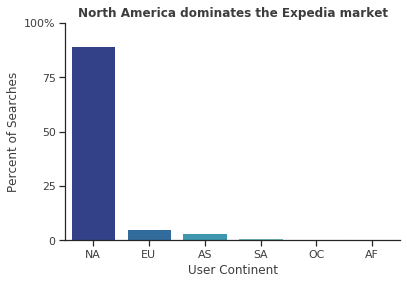

In [0]:
ax = sns.barplot(x='user_location_continent', y='is_mobile', data=ana_df,
                 estimator=lambda x: len(x) / len(ana_df) * 100,
                 palette='YlGnBu_r')
# _ = plt.setp(ax.get_xticklabels(), rotation=90)

ax.set_title('North America dominates the Expedia market', fontsize=12,
             fontweight='semibold', color='#3D3D3D')
ax.set_xlabel('User Continent', color='#3D3D3D')
ax.set_xticklabels(ana_df['user_location_continent'].unique().tolist(),
                   color='#3D3D3D')
ax.set_ylabel('Percent of Searches', color='#3D3D3D');
ax.set_yticklabels([0, 25, 50, 75, '100%'], color='#3D3D3D')

# Set the y-axis ticks
ax.set_yticks(range(0,101,25))

sns.despine()

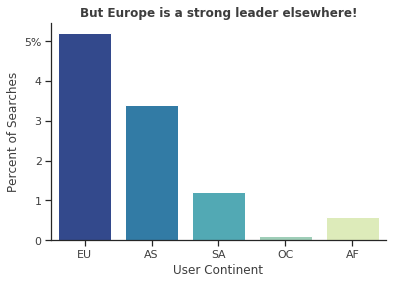

In [0]:
ax = sns.barplot(x='user_location_continent', y='is_mobile',
                 data=ana_df[ana_df['user_location_continent'] != 'NA'],
                 estimator=lambda x: len(x) / len(ana_df) * 100,
                 palette='YlGnBu_r')
# _ = plt.setp(ax.get_xticklabels(), rotation=90)

ax.set_title('But Europe is a strong leader elsewhere!', fontsize=12,
             fontweight='semibold', color='#3D3D3D')
ax.set_xlabel('User Continent', color='#3D3D3D')
ax.set_xticklabels(ana_df['user_location_continent'].unique().tolist()[1:],
                   color='#3D3D3D')
ax.set_ylabel('Percent of Searches', color='#3D3D3D');
ax.set_yticklabels([0, 1, 2, 3, 4, '5%'], color='#3D3D3D')

sns.despine()

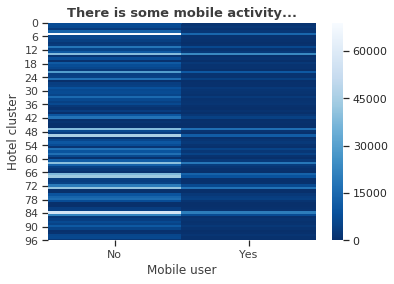

In [0]:
mobile_cluster = pd.crosstab(ana_df['hotel_cluster'], ana_df['is_mobile'])
ax = sns.heatmap(mobile_cluster, cmap='Blues_r')
ax.set_title('There is some mobile activity...', fontsize=13,
             fontweight='semibold', color='#3D3D3D')
ax.set_xlabel('Mobile user', color='#3D3D3D')
ax.set_xticklabels(['No', 'Yes'], color='#3D3D3D')
ax.set_ylabel('Hotel cluster', color='#3D3D3D');
ax.set_yticklabels(range(0,100,6), color='#3D3D3D');

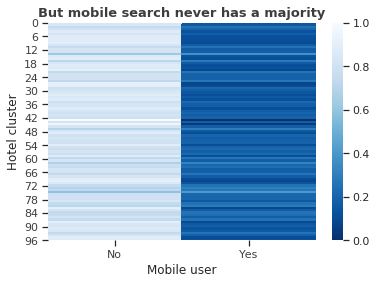

In [0]:
mobile_cluster = pd.crosstab(ana_df['hotel_cluster'], ana_df['is_mobile'],
                             normalize='index')
ax = sns.heatmap(mobile_cluster, cmap='Blues_r')
ax.set_title('But mobile search never has a majority', fontsize=13,
             fontweight='semibold', color='#3D3D3D')
ax.set_xlabel('Mobile user')
ax.set_xticklabels(['No', 'Yes'], color='#3D3D3D')
ax.set_ylabel('Hotel cluster');
ax.set_yticklabels(range(0,100,6), color='#3D3D3D');

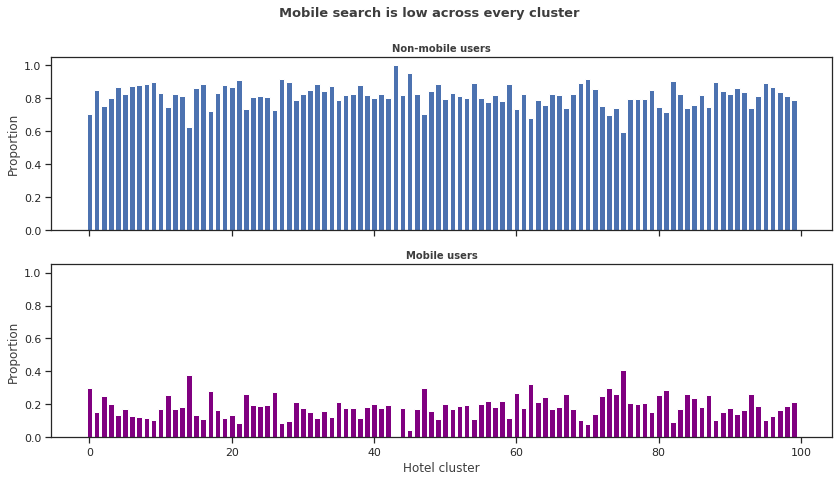

In [0]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(14,7))
ax[0].bar(range(0,100), mobile_cluster[0].values.tolist())
ax[0].set_title('Non-mobile users', fontsize=10,
             fontweight='semibold', color='#3D3D3D')
ax[0].set_ylabel('Proportion', color='#3D3D3D')
ax[1].bar(range(0,100), mobile_cluster[1].values.tolist(), color='purple')
ax[1].set_title('Mobile users', fontsize=10,
             fontweight='semibold', color='#3D3D3D')
ax[1].set_ylabel('Proportion', color='#3D3D3D')
ax[1].set_xlabel('Hotel cluster', color='#3D3D3D')
fig.suptitle('Mobile search is low across every cluster', fontsize=13,
             fontweight='semibold', color='#3D3D3D');

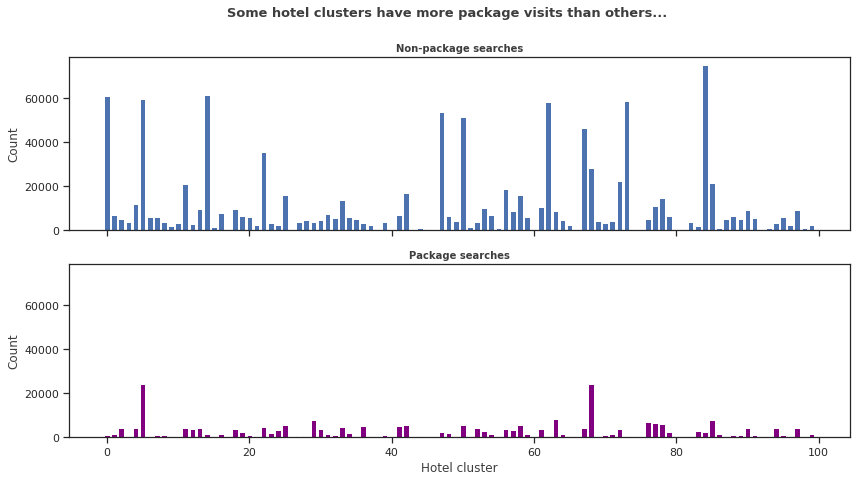

In [0]:
package_cluster = pd.crosstab(ana_df['hotel_cluster'], ana_df['is_package'])
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(14,7))
ax[0].bar(range(0,100), package_cluster[0].values.tolist())
ax[0].set_title('Non-package searches', fontsize=10,
             fontweight='semibold', color='#3D3D3D')
ax[0].set_ylabel('Count', color='#3D3D3D')
ax[1].bar(range(0,100), package_cluster[1].values.tolist(), color='purple')
ax[1].set_title('Package searches', fontsize=10,
             fontweight='semibold', color='#3D3D3D')
ax[1].set_ylabel('Count', color='#3D3D3D')
ax[1].set_xlabel('Hotel cluster', color='#3D3D3D')
fig.suptitle('Some hotel clusters have more package visits than others...',
             fontsize=13, fontweight='semibold', color='#3D3D3D');

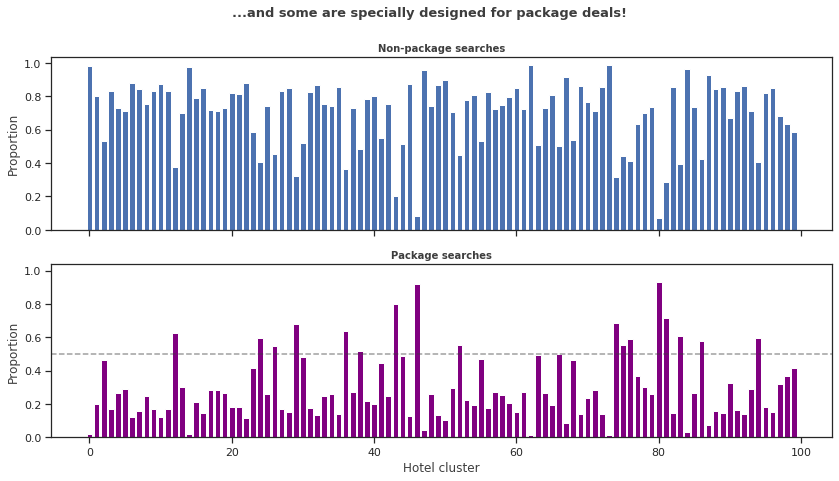

In [0]:
package_cluster = pd.crosstab(ana_df['hotel_cluster'], ana_df['is_package'],
                              normalize='index')
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(14,7))
ax[0].bar(range(0,100), package_cluster[0].values.tolist())
ax[0].set_title('Non-package searches', fontsize=10,
             fontweight='semibold', color='#3D3D3D')
ax[0].set_ylabel('Proportion', color='#3D3D3D')
ax[1].bar(range(0,100), package_cluster[1].values.tolist(), color='purple')
ax[1].set_title('Package searches', fontsize=10,
             fontweight='semibold', color='#3D3D3D')
ax[1].set_ylabel('Proportion', color='#3D3D3D')
ax[1].set_xlabel('Hotel cluster', color='#3D3D3D')
ax[1].axhline(y=0.5, linewidth=1.5, linestyle='--', color='#3D3D3D', alpha=0.5)
fig.suptitle('...and some are specially designed for package deals!',
             fontsize=13, fontweight='semibold', color='#3D3D3D');

We can see several clusters that favor package deals over non-package deals. 17 of the 100 clusters are favored for package deals -- the two largest are cluster 46 with 92% and cluster 80 with 93%. Though the proportions are high, the total counts are quite low for these clusters, leaving room for future targeting.

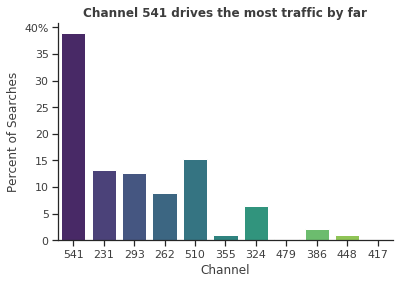

In [0]:
ax = sns.barplot(x='channel', y='is_mobile',
                 data=ana_df,
                 estimator=lambda x: len(x) / len(ana_df) * 100,
                 palette='viridis',
                 order=ana_df['channel'].unique().tolist())
# _ = plt.setp(ax.get_xticklabels(), rotation=90)

ax.set_title('Channel 541 drives the most traffic by far',
             fontsize=12, fontweight='semibold', color='#3D3D3D')
ax.set_xlabel('Channel', color='#3D3D3D')
ax.set_xticklabels(ana_df['channel'].unique().tolist(),
                   color='#3D3D3D')
ax.set_ylabel('Percent of Searches', color='#3D3D3D');
ax.set_yticklabels([0, 5, 10, 15, 20, 25, 30, 35, '40%'], color='#3D3D3D')

sns.despine()

In [0]:
mobile_channel = pd.crosstab(ana_df['channel'], ana_df['is_mobile'],
                              normalize='index')
mobile_channel

is_mobile,0,1
channel,,
231,0.781254,0.218746
262,0.754480,0.245520
293,0.633980,0.366020
324,0.838625,0.161375
355,0.842265,0.157735
386,0.928656,0.071344
417,0.293750,0.706250
448,0.880253,0.119747
479,0.875932,0.124068


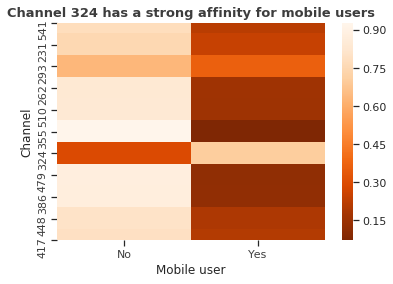

In [0]:
ax = sns.heatmap(mobile_channel, cmap='Oranges_r')
ax.set_title('Channel 324 has a strong affinity for mobile users', fontsize=13,
             fontweight='semibold', color='#3D3D3D')
ax.set_xlabel('Mobile user')
ax.set_xticklabels(['No', 'Yes'], color='#3D3D3D')
ax.set_ylabel('Channel');
ax.set_yticklabels(ana_df['channel'].unique().tolist(), color='#3D3D3D');

In [0]:
month_channel = pd.crosstab(ana_df['month'], ana_df['channel'])

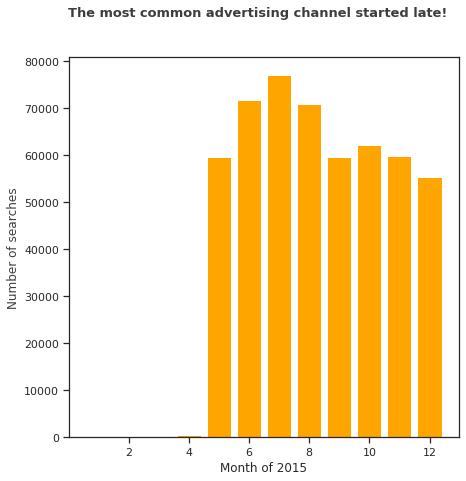

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.bar(range(1,13), month_channel['541'].values.tolist(), color='orange')
ax.set_xlabel('Month of 2015')
ax.set_ylabel('Number of searches', color='#3D3D3D')
fig.suptitle('The most common advertising channel started late!',
             fontsize=13, fontweight='semibold', color='#3D3D3D');

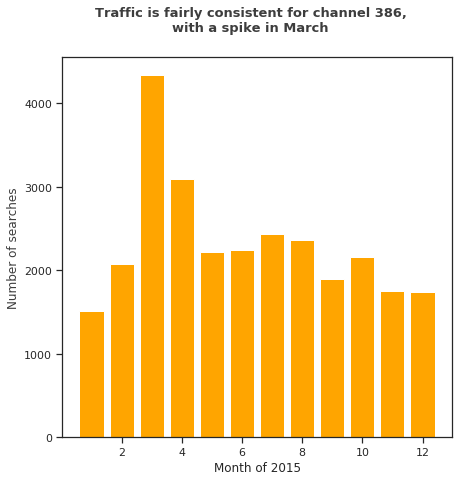

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.bar(range(1,13), month_channel['386'].values.tolist(), color='orange')
ax.set_xlabel('Month of 2015')
ax.set_ylabel('Number of searches', color='#3D3D3D')
fig.suptitle('Traffic is fairly consistent for channel 386,\nwith a spike in March',
             fontsize=13, fontweight='semibold', color='#3D3D3D');

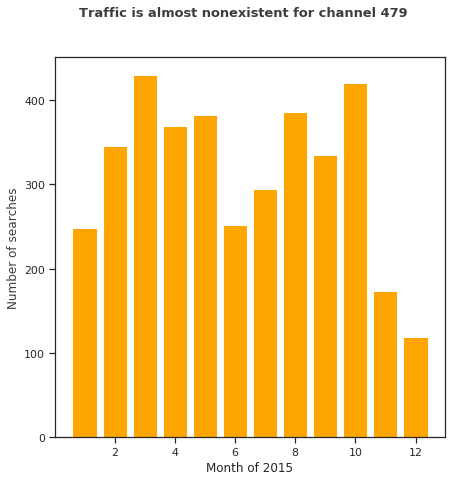

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.bar(range(1,13), month_channel['479'].values.tolist(), color='orange')
ax.set_xlabel('Month of 2015')
ax.set_ylabel('Number of searches', color='#3D3D3D')
fig.suptitle('Traffic is almost nonexistent for channel 479',
             fontsize=13, fontweight='semibold', color='#3D3D3D');